# Partial Differential Equations - Stefan problem

# s like surface, h like height and we are flying

### Time dependent boundary condition

In [260]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import *

In [261]:
def gen_matrixA(M):
    A = np.zeros((M-1, M-1))
    for i in range(M-1):
        A[i][i] = -2
        if 1 <= i < M-1:
            A[i-1][i] = 1
        if 0 <= i < M-2:
            A[i+1][i] = 1
    return A

def gen_matrixB(xs):
    M = len(xs)
    B = np.zeros((M, M))
    for i in range(M):
        if 1 <= i < M:
            B[i-1][i] = xs[i-1]
        if 0 <= i < M-1:
            B[i+1][i] = -xs[i+1]
    return B

def quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s):
    r = dt/dx**2
    v = dt/dx
    return (2*r*(t[1]+t[0])*(F_new[M-1]+F_old[M-1]))-(4*beta/v)*(r+((ksi[M]/(4*dx))*(x**2-s[0]**2)))*(x**2-s[0]**2)

def quartic_prim(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, s):
    return (quartic(x+h, t, F_new, F_old, M, beta, dt, dx, ksi, s) \
            - quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s)) / h

def newton_czy(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, epsilon, s):
    step = 0
    while step < 10**6:
        new_x = x - quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s) \
        / quartic_prim(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, s)
        new_x = abs(new_x)
        #if abs(x - new_x) < epsilon:
        q = quartic(new_x, t, F_new, F_old, M, beta, dt, dx, ksi, s)
        if abs(q) < epsilon:
            return new_x
        x = new_x
        step += 1
    return x

def finite_difference_method(t_max, dt, beta=1, M=10):
    ts = np.arange(0, t_max+dt, 1)*dt
    N = len(ts)
    ksi = np.linspace(0, 1, M+1)
    dx = ksi[1] - ksi[0]
    gamma = 1/np.sqrt(beta)
    s = [0, 0]

    A = 1/(2*dx**2)*gen_matrixA(M+1)
    B = 1/(4*dx)*gen_matrixB(ksi[1:])
    I = np.identity(M)
    
    f = 1 - ksi
    
    result = np.zeros((N, M+1))
    result[0] = f
    st = np.zeros(N)
    old_f = f[1:]
    
    for i in range(1, N):
        tn_12 = (ts[i]+ts[i-1])/2
        sn_12 = (s[1] + s[0])/2
        sp = (s[1] - s[0])/dt
        
        L = tn_12*A - sn_12**2 * (0.5 + tn_12/dt)*I + tn_12*sn_12*sp*B
        R = -tn_12*A + sn_12**2 * (0.5 - tn_12/dt)*I - tn_12*sn_12*sp*B
        D = np.zeros(M)
        if i == 1:
            D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((np.exp(ts[i])-1)/ts[i] + 1)
        else:
            D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((np.exp(ts[i])-1)/ts[i] \
                                                                                   + (np.exp(ts[i-1])-1)/(ts[i-1]))
        new_f = np.linalg.inv(L) @ (R @ old_f + D)
        s_new = newton_czy(s[1], 10**(-6), [ts[i],ts[i-1]], new_f, old_f, M, beta, dt, dx, ksi, 10**(-6), s)
        s = [s_new, s_new]
        #s = [s[1], s_new]
        st[i] = s_new
        f[0] = (np.exp(ts[i])-1)/ts[i] + (np.exp(ts[i-1])-1)/(ts[i-1]) - f[0] if i > 1 else 1
        f[1:] = new_f
        f[-1] = 0
        U = f*ts[i]
        result[i] = U
        old_f = new_f
    return result, st

In [262]:
def ana_sol(t_max, dt, beta, M = 10):
    ts = np.arange(0, t_max+dt, 1)*dt
    ksi = np.linspace(0, 1, M+1)
    gamma = 1/np.sqrt(beta)
    s_ana = np.zeros(len(ts))
    U_ana = [0]*len(ts)
    for i in range(1, len(ts)):
        s_ana[i] = gamma*ts[i]
        U_ana[i] = np.exp(ts[i] - s_ana[i] * ksi) - 1
    return U_ana, s_ana

In [295]:
t = 10
dt = 0.1
beta = 2
M1 = 10
M2 = 10

In [264]:
ana = ana_sol(t, dt, beta, M2)

In [265]:
fdm = finite_difference_method(t, dt, beta, M1)

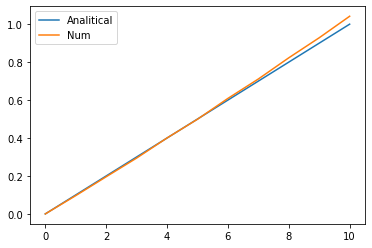

In [266]:
plt.plot(ana[1])
plt.plot(fdm[1])
plt.legend(["Analitical", "Num"])

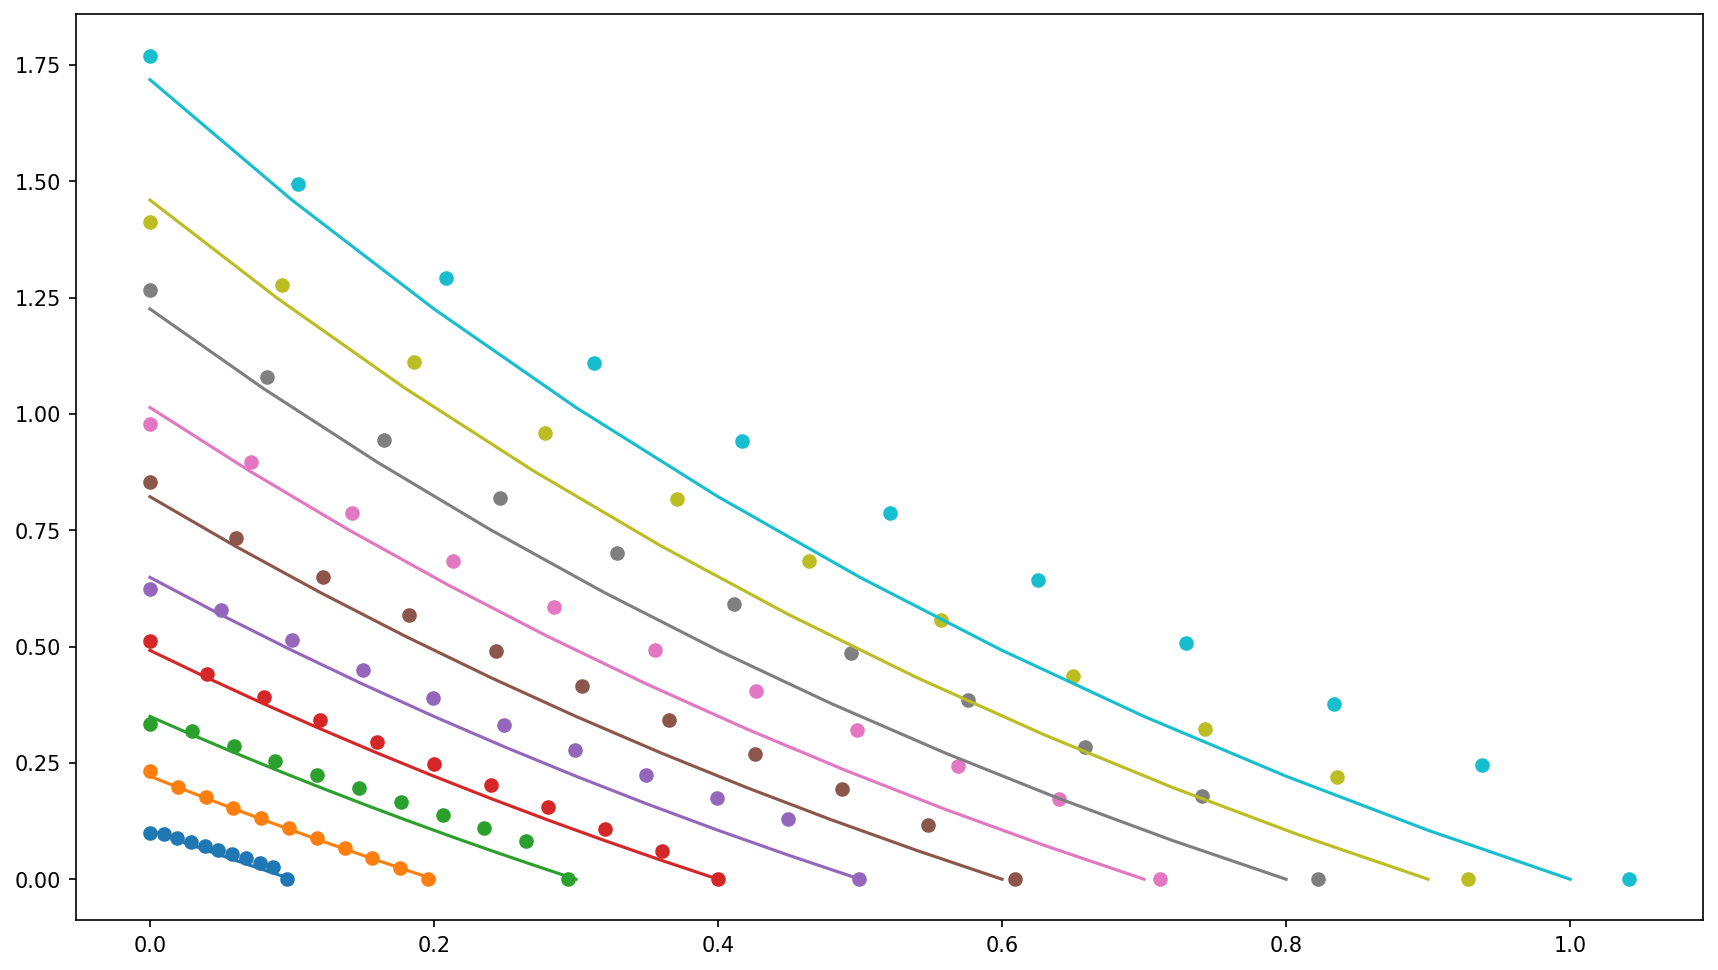

In [267]:
plt.figure(figsize = (14, 8), dpi = 150)
ksi2 = np.linspace(0, 1, M2 + 1)
ksi1 = np.linspace(0, 1, M1 + 1)
for i in range(1, len(ana[0])):
    plt.plot(ksi2*ana[1][i], ana[0][i])
for i in range(1, len(fdm[0])):
    plt.scatter(ksi1*fdm[1][i], fdm[0][i])

### Constant boundary condition

In [351]:
def finite_difference_method2(t_max, dt, beta=1, M=10):
    ts = np.arange(0, t_max+dt, 1)*dt
    N = len(ts)
    ksi = np.linspace(0, 1, M+1)
    dx = ksi[1] - ksi[0]
    s = [0, 0]
    r = dt/(dx*dx)
    v = dt/dx
    
    x = symbols('x')
    alpha = nsolve(np.sqrt(np.pi)*beta*x*erf(x)*exp(x**2) - 1, x, 1)
    
    A = 1/(2*dx**2)*gen_matrixA(M+1)
    B = 1/(8*dx)*gen_matrixB(ksi[1:])
    I = np.identity(M)
    
    f = np.zeros(len(ksi))
    for j in range(len(ksi)):
        f[j] = 1 - (math.erf(alpha*ksi[j])/math.erf(alpha))
    
    result = np.zeros((N, M+1))
    result[0] = f
    st = np.zeros(N)
    old_f = f[1:]
    
    a = beta*ksi[M]/(2*dt)
    
    for i in range(1, N):
        sn_12 = (s[1] + s[0])/2
        sp = (s[1] - s[0])/dt
        
        L = A - (sn_12/dt)*I + sp*B
        R = -(sn_12/dt)*I - sp*B - A
        D = np.zeros(M)
        D[0] = 1/(2*dx*dx) - sp/(8*dx)*ksi[1]
        
        new_f = np.linalg.inv(L) @ (R @ old_f - 2*D)
             
        b = -beta*ksi[M]/dt*s[0] + 2*beta*r/v
        c = beta*ksi[M]/(2*dt) * s[0]*s[0] - 2*beta*r/v*s[0] - 2*r*(new_f[M - 2] + old_f[M - 2])
        delta = b*b - 4*a*c
        s1 = (-b - np.sqrt(delta))/(2*a)
        s2 = (-b + np.sqrt(delta))/(2*a)
        if delta < 0:
            raise ValueError('s_new is complex')
        s_new = max(s1, s2)
        s = [s_new, s_new]
        #s = [s[1], s_new]
        st[i] = s_new
        f[0] = 1
        f[1:] = new_f
        f[-1] = 0
        result[i] = f
        old_f = new_f
    return result, np.sqrt(st)

In [352]:
def ana_soli(t_max, dt, beta, M = 10):
    x = symbols('x')
    alpha = nsolve(np.sqrt(np.pi)*beta*x*erf(x)*exp(x**2) - 1, x, 1)
    ts = np.arange(0, t_max+dt, 1)*dt
    ksi = np.linspace(0, 1, M+1)
    U_ana = [0]*len(ts)
    s_ana = 2*alpha*np.sqrt(ts)
    for i in range(1, len(ts)):
        U = np.zeros(len(ksi))
        for j in range(len(ksi)):
            U[j] = 1 - (math.erf(alpha*ksi[j])/math.erf(alpha))
        U_ana[i] = U
    return U_ana, s_ana

In [353]:
fdm2 = finite_difference_method2(t, dt, beta, M1)
ana2 = ana_soli(t, dt, beta, M2)

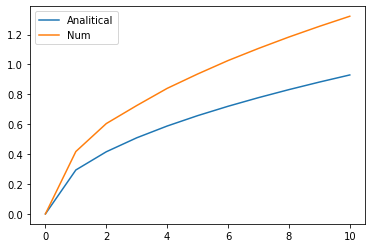

In [354]:
plt.plot(ana2[1])
plt.plot(fdm2[1])
plt.legend(["Analitical", "Num"])

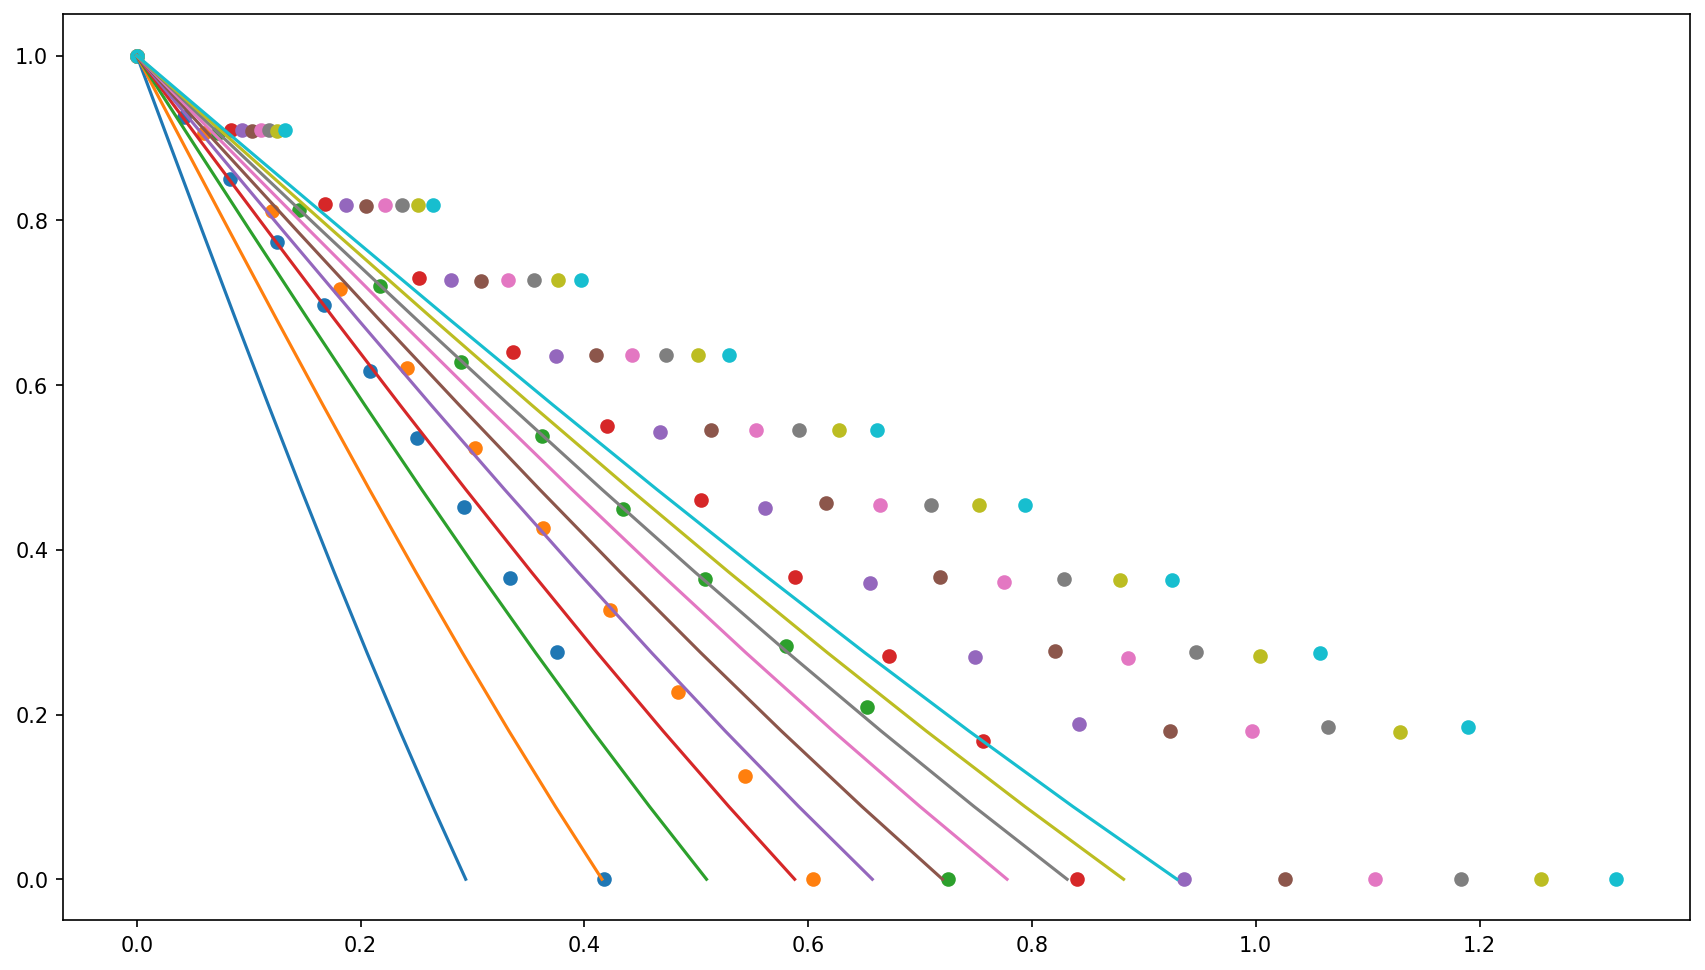

In [346]:
plt.figure(figsize = (14, 8), dpi = 150)
ksi1 = np.linspace(0, 1, M1 + 1)
for i in range(1, len(ana2[0])):
    plt.plot(ksi2*ana2[1][i], ana2[0][i])
for i in range(1, len(fdm2[0])):
    plt.scatter(ksi1*fdm2[1][i], fdm2[0][i])

## useful

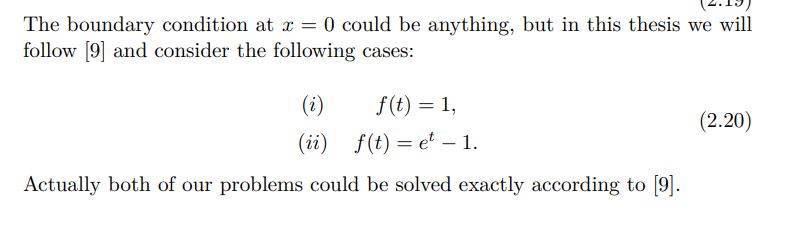

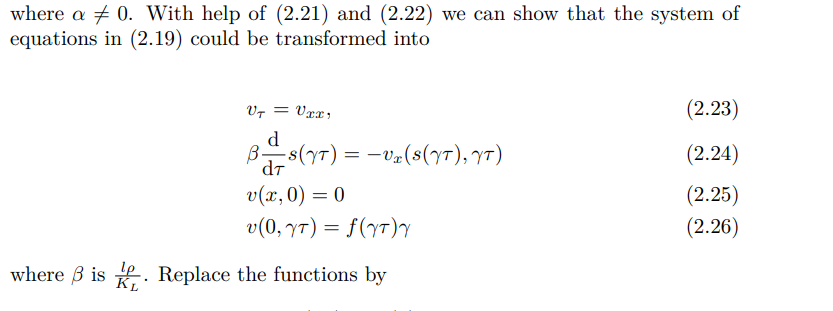

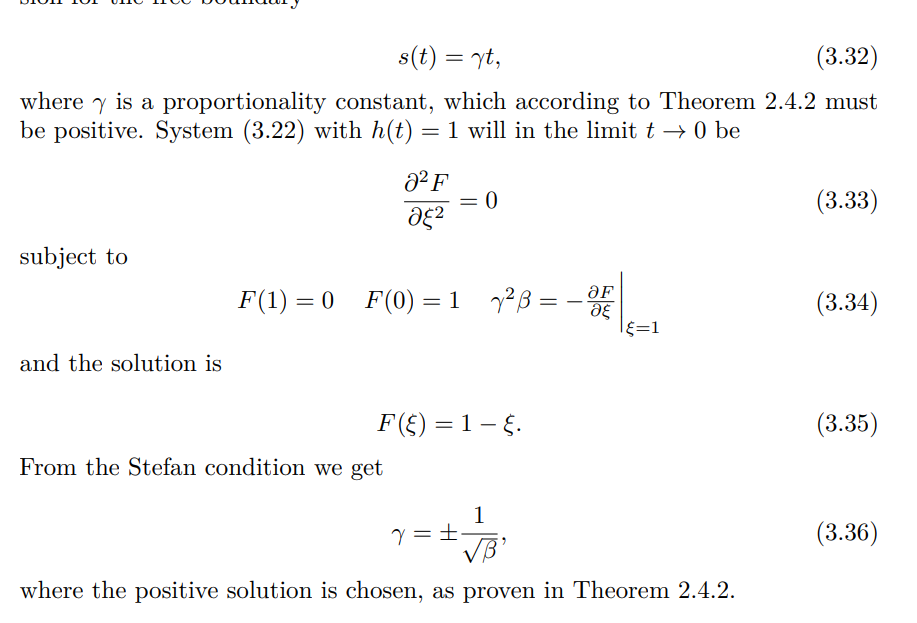

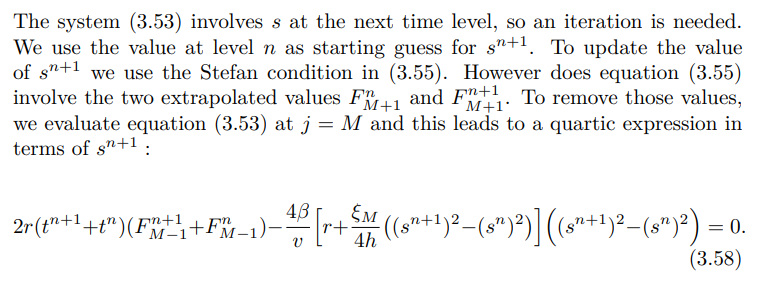

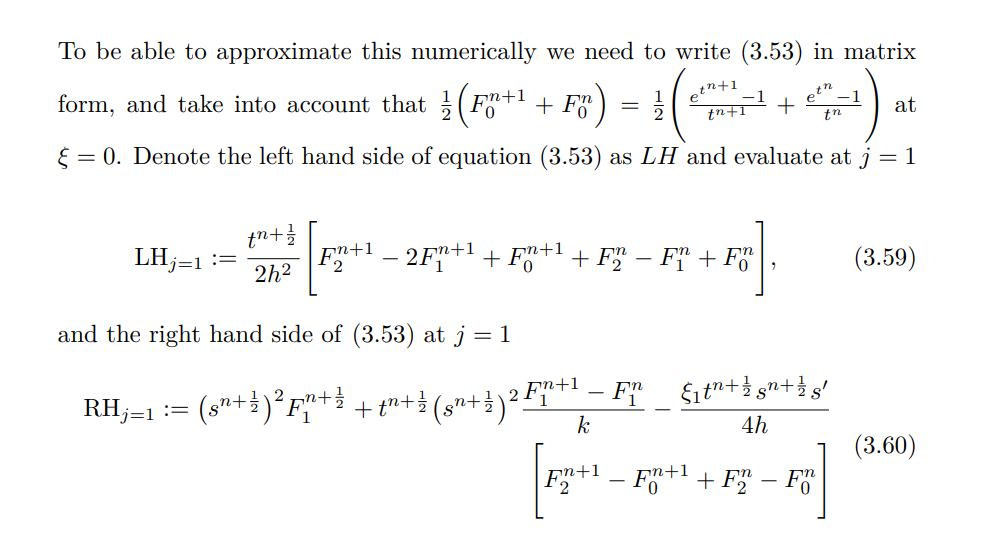

In [203]:
def ana_soliii(t_max, dt, beta, M = 10):
    gamma = 1/beta
    ts = np.arange(0, t_max+dt, 1)*dt
    ksi = np.linspace(0, 1, M+1)
    s_ana = np.zeros(len(ts))
    U_ana = [0]*len(ts)
    for i in range(1, len(ts)):
        s_ana[i] = gamma*ts[i]
        U_ana[i] = (1 - ksi)*s_ana[i]
    return U_ana, s_ana 